In [1]:
import pandas as pd
from astral.sun import sun
from astral import LocationInfo

LOCATION = (51.365967, 6.172045) # Venlo, NL

#TZ= "Europe/Amsterdam"
from datetime import datetime, time, timedelta

T_MIN = time(7,0) # minimum time 
RISE_OFFSET = timedelta(minutes=20)
SET_OFFSET = timedelta(minutes=25)


def time_to_decimal(t):
    """Convert time to decimal hours."""
    return t.hour + t.minute / 60 + t.second / 3600


def calculate_sun_times(latitude, longitude, tz= "UTC"):
    """Calculates sunrise and sunset times and returns them as time objects."""
    # Define the location
    location = LocationInfo(latitude=latitude, longitude=longitude)

    # Create a pandas DataFrame to hold sunrise and sunset times
    date_range = pd.date_range(start="2023-12-01", end="2030-12-31")
    sunrise_times = []
    sunset_times = []

    for day in date_range:
        s = sun(location.observer, date=day, tzinfo=tz)
        sunrise_times.append(s['sunrise'])
        sunset_times.append(s['sunset'])

    # Create DataFrame
    df = pd.DataFrame(index=date_range, data={'rise': sunrise_times, 'set': sunset_times})
    return df




In [2]:
t_local = calculate_sun_times(*LOCATION, tz = "Europe/Amsterdam")

t_local["rise"] = t_local["rise"]+ RISE_OFFSET
t_local["set"] = t_local["set"] + SET_OFFSET

# remove date
t_local = t_local.map(lambda v : v.time())


In [3]:
# limit morning time
s = t_local.rise
s[s<T_MIN] = T_MIN

t_local

,rise,set
2023-12-01,08:37:51.099592,16:55:15.805266
2023-12-02,08:39:14.238548,16:54:39.069809
2023-12-03,08:40:35.482012,16:54:05.472074
2023-12-04,08:41:54.744534,16:53:35.050364
2023-12-05,08:43:11.941198,16:53:07.840588
...,...,...
2030-12-27,09:00:19.467502,16:57:28.737382
2030-12-28,09:00:29.494737,16:58:18.397997
2030-12-29,09:00:36.171618,16:59:11.033117
2030-12-30,09:00:39.493963,17:00:06.582308


In [4]:
t_utc = calculate_sun_times(*LOCATION, tz = "UTC")

t_utc

,rise,set
2023-12-01,2023-12-01 07:17:51.099592+00:00,2023-12-01 15:30:15.805266+00:00
2023-12-02,2023-12-02 07:19:14.238548+00:00,2023-12-02 15:29:39.069809+00:00
2023-12-03,2023-12-03 07:20:35.482012+00:00,2023-12-03 15:29:05.472074+00:00
2023-12-04,2023-12-04 07:21:54.744534+00:00,2023-12-04 15:28:35.050364+00:00
2023-12-05,2023-12-05 07:23:11.941198+00:00,2023-12-05 15:28:07.840588+00:00
...,...,...
2030-12-27,2030-12-27 07:40:19.467502+00:00,2030-12-27 15:32:28.737382+00:00
2030-12-28,2030-12-28 07:40:29.494737+00:00,2030-12-28 15:33:18.397997+00:00
2030-12-29,2030-12-29 07:40:36.171618+00:00,2030-12-29 15:34:11.033117+00:00
2030-12-30,2030-12-30 07:40:39.493963+00:00,2030-12-30 15:35:06.582308+00:00


In [5]:
# convert to utc
import pytz
from datetime import datetime

# Define a function to convert to UTC
amsterdam_tz = pytz.timezone('Europe/Amsterdam')

def to_utc(time_obj, date):
    local_dt = amsterdam_tz.localize(datetime.combine(date, time_obj))
    utc_dt = local_dt.astimezone(pytz.utc)
    return utc_dt.time()

# Apply the conversion
df = t_local
df['open'] = list(map(to_utc, df['rise'], df.index))
df['close'] = list(map(to_utc, df['set'], df.index))


<Axes: >

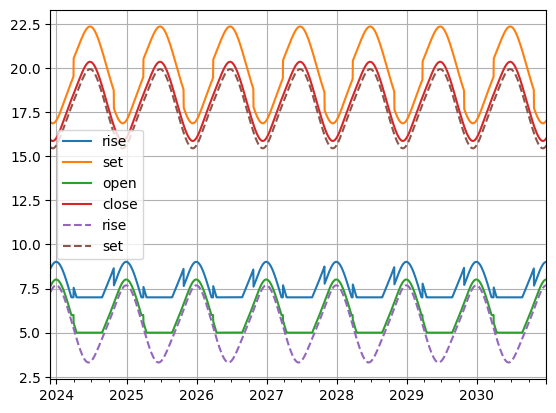

In [9]:
ax = df.map(time_to_decimal).plot()
t_utc.map(time_to_decimal).plot(ax=ax, style='--',grid=True)

In [10]:
lut = df[["open","close"]].map(time_to_decimal)
lut.to_csv("sun_lut.csv", float_format = "%.2f",header=None)